# Data Cleaning

In [1]:
# Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import warnings

import seaborn as sb
import matplotlib.pyplot as plt

import random
import math

from sklearn.linear_model import LinearRegression
from scipy.stats import norm

In [3]:
# Sopprimere i Warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Cyclists

In [4]:
csv_file = "../data/cyclists.csv"
cyclists_dataset = pd.read_csv(csv_file)
cyclists_dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [5]:
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


### Modify columns

Before cleaning the races dataset, we redefine the dataframe with the new types.

In [6]:
cyclists_dataset['birth_year'] = cyclists_dataset[cyclists_dataset['birth_year'].notnull()]['birth_year'].astype(int)

### Imputation

In [7]:
cyclists_dataset.isnull().sum() # check number of missing values

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

#### Imputation Birth Year and Nationality null values
Per l'anno di nascita e la nazionalità mancanti, abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online.

In [8]:
# Show urls of the cyclists with 'birth_year' missing values
cyclists_dataset[cyclists_dataset['birth_year'].isnull()]['_url']

9             scott-davies
601       vladimir-malakov
894         antonio-zanini
2408     filippo-simonetti
2515         carlos-garcia
2536       alexandr-osipov
3046      nicolai-kosyakov
3551            nevens-guy
4142           oscar-pumar
4384         javier-luquin
4756        thierry-lauder
6072    sergei-jermachenko
6080       batik-odriozola
Name: _url, dtype: object

Per gli anni di nascita trovati, abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [9]:
cyclists_dataset.loc[cyclists_dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
cyclists_dataset.loc[cyclists_dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
cyclists_dataset.loc[cyclists_dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
cyclists_dataset.loc[cyclists_dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
cyclists_dataset.loc[cyclists_dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies.

In [10]:
cyclists_dataset.loc[cyclists_dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

Per i restanti anni di nascita, è stata sfruttata la moda

In [11]:
cyclists_dataset['birth_year'] = cyclists_dataset['birth_year'].fillna(cyclists_dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

In [12]:
cyclists_dataset['birth_year'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

#### Imputation Weight and Height null values

Sapendo che altezza e peso sono altamente correlati, si può sfruttare il peso per trovare l'altezza, e l'altezza per trovare il peso.

In [13]:
# Filter rows where 'weight' is null and 'height' is not null
missing_weight_with_height = cyclists_dataset[cyclists_dataset['weight'].isnull() & cyclists_dataset['height'].notnull()]
print("Cyclists where we have only the height:", len(missing_weight_with_height))

# Filter rows where 'weight' is not null and 'height' is null
missing_height_with_weight = cyclists_dataset[cyclists_dataset['weight'].notnull() & cyclists_dataset['height'].isnull()]
print("Cyclists where we have only the weight:", len(missing_height_with_weight))


Cyclists where we have only the height: 72
Cyclists where we have only the weight: 7


Per questa imputazione, abbiamo pensato a due possibili metodi. Uno è quello di creare un piccolo modello di regressione lineare, un'altro è quello di basarsi sulla media delle distribuzioni suddivise in vari bins.

In [14]:
def linear_regression_imputation():
    # Filtra il dataset per ciclisti con peso e altezza presenti
    available_data = cyclists_dataset.dropna(subset=['weight', 'height'])

    # Modello di regressione per stimare il peso in base all'altezza
    model_weight = LinearRegression()
    model_weight.fit(available_data[['height']], available_data['weight'])

    # Calcolo dei residui per il modello peso-altezza
    weight_predicted = model_weight.predict(available_data[['height']])
    weight_residuals = available_data['weight'] - weight_predicted

    # Modello di regressione per stimare l'altezza in base al peso
    model_height = LinearRegression()
    model_height.fit(available_data[['weight']], available_data['height'])

    # Calcolo dei residui per il modello altezza-peso
    height_predicted = model_height.predict(available_data[['weight']])
    height_residuals = available_data['height'] - height_predicted

    # Funzione per imputare il peso basato sull'altezza
    def impute_weight(height):
        height_df = pd.DataFrame([[height]], columns=['height'])
        predicted_weight = model_weight.predict(height_df)[0]
        imputed_weight = predicted_weight + np.random.choice(weight_residuals)
        return imputed_weight

    # Funzione per imputare l'altezza basata sul peso
    def impute_height(weight):
        weight_df = pd.DataFrame([[weight]], columns=['weight'])
        predicted_height = model_height.predict(weight_df)[0]
        imputed_height = predicted_height + np.random.choice(height_residuals)
        return imputed_height

    # Crea una copia del dataset per l'imputazione
    imputed_dataset = cyclists_dataset.copy()

    # Applica l'imputazione alla copia del dataset per i ciclisti con altezza disponibile ma peso mancante
    imputed_dataset.loc[imputed_dataset['weight'].isnull() & imputed_dataset['height'].notnull(), 'weight'] = \
        imputed_dataset.loc[imputed_dataset['weight'].isnull() & imputed_dataset['height'].notnull(), 'height'].apply(impute_weight)

    # Applica l'imputazione alla copia del dataset per i ciclisti con peso disponibile ma altezza mancante
    imputed_dataset.loc[imputed_dataset['height'].isnull() & imputed_dataset['weight'].notnull(), 'height'] = \
        imputed_dataset.loc[imputed_dataset['height'].isnull() & imputed_dataset['weight'].notnull(), 'weight'].apply(impute_height)

    return imputed_dataset

imputed_dataset_lr = linear_regression_imputation()
imputed_dataset_lr.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        0
weight         2984
height         2984
nationality       0
dtype: int64

In [15]:
def bins_imputation():
    # Creare una copia del dataset originale per l'imputazione
    imputed_dataset = cyclists_dataset.copy()

    # Creare intervalli per altezza e peso (ad esempio per decili o range)
    # Qui useremo i decili per distribuire altezza e peso in intervalli
    imputed_dataset['height_bin'] = pd.qcut(imputed_dataset['height'], q=10)  # Decili per l'altezza
    imputed_dataset['weight_bin'] = pd.qcut(imputed_dataset['weight'], q=10)  # Decili per il peso

    # Calcolare la media del peso per ogni intervallo di altezza
    height_weight_means = imputed_dataset.groupby('height_bin')['weight'].mean()

    # Calcolare la media dell'altezza per ogni intervallo di peso
    weight_height_means = imputed_dataset.groupby('weight_bin')['height'].mean()

    # Funzione per imputare il peso in base all'intervallo di altezza
    def impute_weight_simple(row):
        if pd.isnull(row['weight']) and pd.notnull(row['height']):
            # Cerca il peso medio corrispondente all'intervallo di altezza
            return height_weight_means[row['height_bin']]
        return row['weight']

    # Funzione per imputare l'altezza in base all'intervallo di peso
    def impute_height_simple(row):
        if pd.isnull(row['height']) and pd.notnull(row['weight']):
            # Cerca l'altezza media corrispondente all'intervallo di peso
            return weight_height_means[row['weight_bin']]
        return row['height']

    # Applicare le funzioni di imputazione sulla copia del dataset
    imputed_dataset['weight'] = imputed_dataset.apply(impute_weight_simple, axis=1)
    imputed_dataset['height'] = imputed_dataset.apply(impute_height_simple, axis=1)

    # Rimuovere le colonne di supporto usate per l'imputazione
    imputed_dataset.drop(columns=['height_bin', 'weight_bin'], inplace=True)

    return imputed_dataset

imputed_dataset_bins = bins_imputation()

imputed_dataset_bins[['weight', 'height']].isnull().sum() # check if missing values are filled correctly

weight    2984
height    2984
dtype: int64

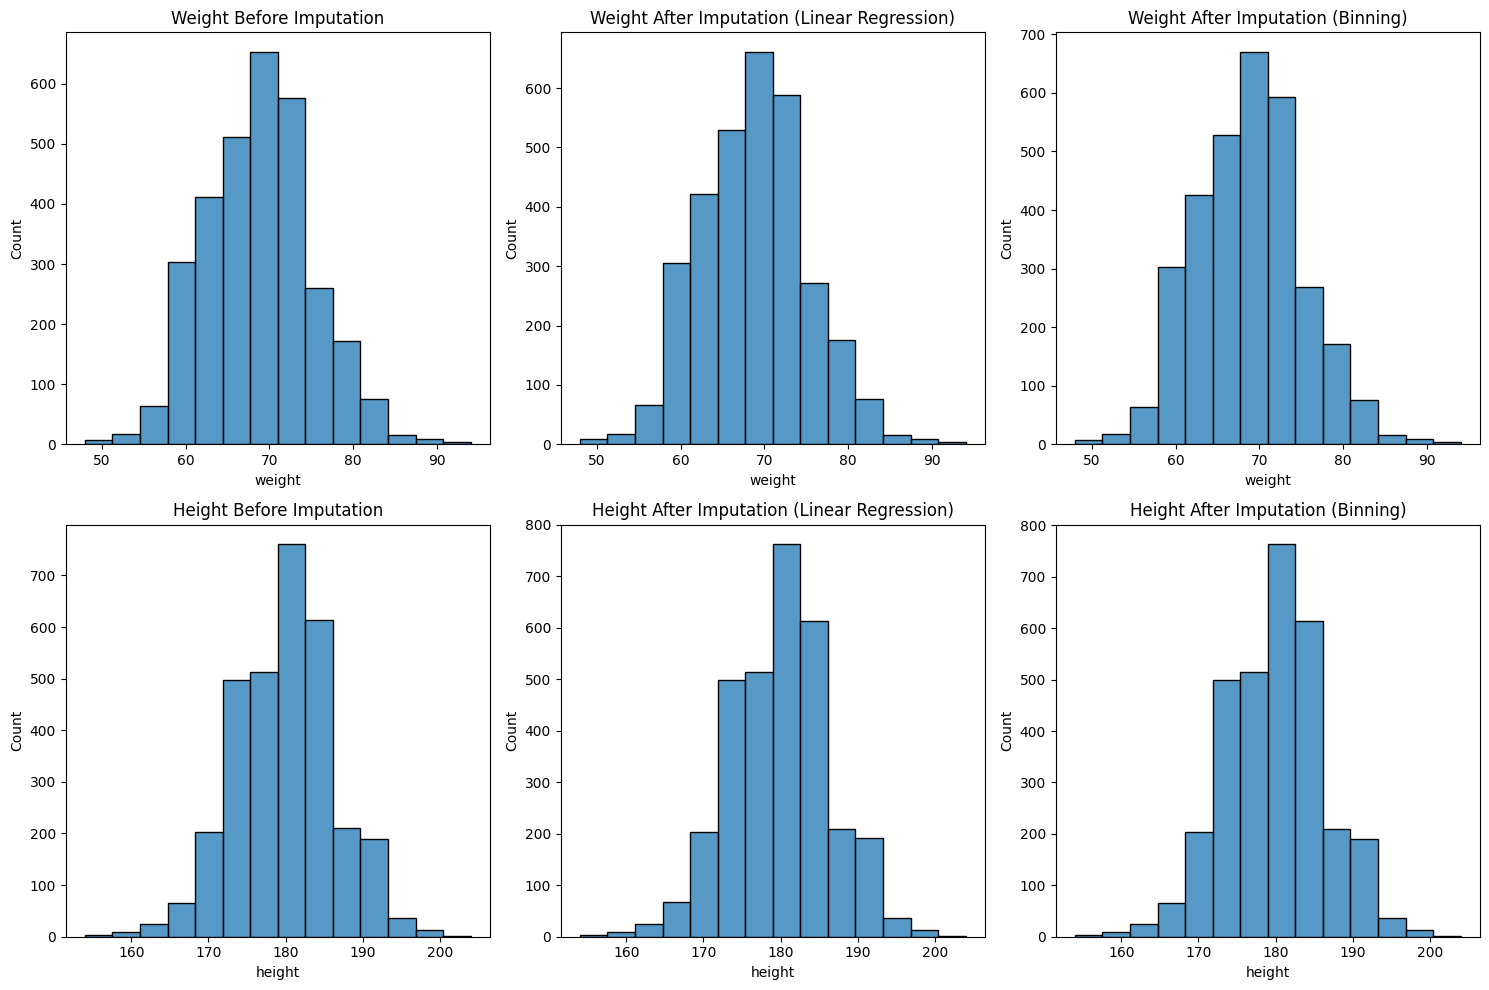

In [16]:
# Calcola il numero di bin per l'istogramma
n_bins = math.ceil(math.log2(len(cyclists_dataset)) + 1)

# Crea una griglia 2x3 per i grafici
fig, axes = plt.subplots(2, 3, figsize=(15, 10))


# Peso prima dell'imputazione
sb.histplot(data=cyclists_dataset, x="weight", bins=n_bins, ax=axes[0, 0])
axes[0, 0].set_title("Weight Before Imputation")

# Peso dopo l'imputazione (regressione lineare)
sb.histplot(data=imputed_dataset_lr, x="weight", bins=n_bins, ax=axes[0, 1])
axes[0, 1].set_title("Weight After Imputation (Linear Regression)")

# Peso dopo l'imputazione (binning)
sb.histplot(data=imputed_dataset_bins, x="weight", bins=n_bins, ax=axes[0, 2])
axes[0, 2].set_title("Weight After Imputation (Binning)")


# Altezza prima dell'imputazione
sb.histplot(data=cyclists_dataset, x="height", bins=n_bins, ax=axes[1, 0])
axes[1, 0].set_title("Height Before Imputation")

# Altezza dopo l'imputazione (regressione lineare)
sb.histplot(data=imputed_dataset_lr, x="height", bins=n_bins, ax=axes[1, 1])
axes[1, 1].set_title("Height After Imputation (Linear Regression)")

# Altezza dopo l'imputazione (binning)
sb.histplot(data=imputed_dataset_bins, x="height", bins=n_bins, ax=axes[1, 2])
axes[1, 2].set_title("Height After Imputation (Binning)")


# Imposta uno stile di layout compatto
plt.tight_layout()
plt.show()

Entrambi i metodi riescono correttamente a imputare i valori di interesse. Inoltre, notiamo dalle distribuzioni che non è presente una grande differenza, ma comunque l'imputazione con il secondo metodo mantiene una distribuzione più coerente con quella iniziale, quindi andremo ad effettuare l'imputazione sfruttando la media nella distribuzione.

In [17]:
# Creare intervalli per altezza e peso (ad esempio per decili o range)
# Qui useremo i decili per distribuire altezza e peso in intervalli
cyclists_dataset['height_bin'] = pd.qcut(cyclists_dataset['height'], q=10)  # Decili per l'altezza
cyclists_dataset['weight_bin'] = pd.qcut(cyclists_dataset['weight'], q=10)  # Decili per il peso

# Calcolare la media del peso per ogni intervallo di altezza
height_weight_means = cyclists_dataset.groupby('height_bin')['weight'].mean()

# Calcolare la media dell'altezza per ogni intervallo di peso
weight_height_means = cyclists_dataset.groupby('weight_bin')['height'].mean()

# Funzione per imputare il peso in base all'intervallo di altezza
def impute_weight_simple(row):
    if pd.isnull(row['weight']) and pd.notnull(row['height']):
        # Cerca il peso medio corrispondente all'intervallo di altezza
        return height_weight_means[row['height_bin']]
    return row['weight']

# Funzione per imputare l'altezza in base all'intervallo di peso
def impute_height_simple(row):
    if pd.isnull(row['height']) and pd.notnull(row['weight']):
        # Cerca l'altezza media corrispondente all'intervallo di peso
        return weight_height_means[row['weight_bin']]
    return row['height']

# Applicare le funzioni di imputazione
cyclists_dataset['weight'] = cyclists_dataset.apply(impute_weight_simple, axis=1)
cyclists_dataset['height'] = cyclists_dataset.apply(impute_height_simple, axis=1)

# Rimuovere le colonne di supporto usate per l'imputazione
cyclists_dataset.drop(columns=['height_bin', 'weight_bin'], inplace=True)

# Arrotondare il peso a una cifra decimale e l'altezza a zero cifre decimali
cyclists_dataset['weight'] = cyclists_dataset['weight'].round(1)
cyclists_dataset['height'] = cyclists_dataset['height'].round(0)

In [18]:
cyclists_dataset[['weight', 'height']].isnull().sum() # check if missing values are filled correctly

weight    2984
height    2984
dtype: int64

Per i restanti null values, è nostra intenzione eliminare i record dei ciclisti senza altezza e peso che non sono presenti nelle gare, e questo verrà fatto automaticamente quando a breve andremo ad unire i due dataset.
Non eliminiamo tutti i record con peso e altezza nulli perchè potremmo comunque fare delle analisi basandoci sugli altri valori.


In [19]:
# Order cyclists dataset by _url
cyclists_dataset = cyclists_dataset.sort_values(by='_url')

## Races

In [102]:
csv_file = "../data/races.csv"
races_dataset = pd.read_csv(csv_file)
races_dataset.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


### Modify columns

Before cleaning the races dataset, we redefine the dataframe with the modified columns of date and is_foo

In [103]:
races_dataset['climb_total'] = races_dataset[races_dataset['climb_total'].notnull()]['climb_total'].astype(int)

races_dataset['profile'] = races_dataset['profile'].astype('category')

races_dataset['cyclist_age'] = races_dataset[races_dataset['cyclist_age'].notnull()]['cyclist_age'].astype(int)

races_dataset['date'] = races_dataset['date'].str.split(' ').str[0]
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')

races_dataset = races_dataset.drop(columns=['is_cobbled', 'is_gravel'])
races_dataset = races_dataset.rename(columns={'is_tarmac': 'mostly_tarmac'})

races_dataset = races_dataset.drop(columns=['average_temperature'])

Inoltre iniziamo ad aggiungere la colonna "year" (per l'anno della gara) e la colonna "stage" (per lo stage della gara) che andremo ad utilizzare frequentemente per l'imputation.

In [104]:
races_dataset['year'] = pd.to_datetime(races_dataset['date']).dt.year
races_dataset['stage'] = races_dataset['_url'].str.split('/', expand=True)[2]

### Deletions of rows

Considerando la presenza di uno stesso ciclista più volte (massimo due volte) nella stessa classifica di una specifica gara, abbiamo deciso di eliminare la seconda occorrenza e tenere solo la prima.

In [105]:
# Identify duplicate rows for each cyclist in each URL (excluding the first occurrence)
duplicate_rows = races_dataset.duplicated(subset=['_url', 'cyclist'], keep='first')
# Delete only the second occurrences (duplicate)
races_dataset = races_dataset[~duplicate_rows]

In [106]:
races_dataset.isnull().sum() # check number of missing values

_url                      0
name                      0
points                  477
uci_points           338654
length                    0
climb_total          146976
profile              148089
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

### Imputation

In [48]:
races_dataset.isnull().sum() # check number of missing values

_url                      0
name                      0
points                  477
uci_points           338654
length                    0
climb_total          146976
profile              148089
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

#### Imputation of points and uci points

Proviamo a fare l'imputaton dei points e uci_points mancanti

Partendo dai points, faremo l'imputazione considerando i punteggi delle gare "vicine", ossia considerando il punteggio della stessa gara ma che è stata effettuata un altro anno, basandoci sull'anno più vicino alla gara su cui imputare.

In [49]:
# Ottieni dati unici basati su '_url' e 'points'
unique_data = races_dataset.drop_duplicates(subset=['_url', 'points'])

# Filtra le righe dove 'points' è nullo
invalid_races = unique_data[unique_data['points'].isnull()]
for url, name, year in invalid_races[['_url', 'name', 'year']].values:
    print(f"Missing points for {url}, race {name} in {year}")

Missing points for vuelta-a-espana/1994/stage-5, race Vuelta a España in 1994
Missing points for tour-de-france/1986/stage-19, race Tour de France in 1986
Missing points for tour-de-france/1988/prologue, race Tour de France in 1988
Missing points for tour-de-france/2019/stage-19, race Tour de France in 2019


In [50]:
# Get the name and year and check the the two near races, before and after the current year
for name, stage, year in invalid_races[['name', 'stage', 'year']].values:
    race_before = unique_data[
        (unique_data['name'] == name) & (unique_data['stage'] == stage) &
        (unique_data['year'] < year)
        ].sort_values(by='year', ascending=False).head(1)
    race_after = unique_data[
        (unique_data['name'] == name) & (unique_data['stage'] == stage) &
        (unique_data['year'] > year)
        ].sort_values(by='year', ascending=True).head(1)
    print(f"For race {name} in {name}: \n"
          f"the race before has {race_before['points'].values} points, and the race after has {race_after['points'].values} points")

For race Vuelta a España in Vuelta a España: 
the race before has [80.] points, and the race after has [80.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points


In [51]:
# Loop su ogni riga senza punti e tenta di trovare il valore dell'anno precedente
for index, row in invalid_races.iterrows():
    # Trova la riga dell'anno più recente con lo stesso 'name' ma con 'year' minore
    previous_race = unique_data[
        (unique_data['name'] == row['name']) & (unique_data['stage'] == row['stage']) &
        (unique_data['year'] < row['year'])
        ].sort_values(by='year', ascending=False).head(1)
    
    # Verifica se è stata trovata una riga corrispondente
    if not previous_race.empty:
        # Ottieni i punti della riga trovata
        previous_points = previous_race.iloc[0]['points']
        
        # Assegna questi punti alla riga originale nel dataset
        races_dataset.loc[races_dataset['_url'] == row['_url'], 'points'] = previous_points

races_dataset['points'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

Ora, passiamo agli uci points, dove sfruttiamo il valori delle gare in anni diversi, oppure i valori di points con le varie medie.

In [52]:
# Filtra le righe con 'year' >= 2001 e 'uci_points' null
invalid_races = races_dataset[(races_dataset['year'] > 2000) & races_dataset['uci_points'].isnull()].sort_values(by='year')

# Trova le gare (stage) dove 'uci_points' è sempre nullo
n_points = races_dataset.groupby(['name', 'stage'])['uci_points'].nunique()
stages_without_points = n_points[n_points == 0].index  # Ottieni le combinazioni (name, stage)

In [53]:
# Loop per cicli di imputazione fino a quando non vengono più modificati valori
converged = False

while not converged:
    # Filtra le righe con 'year' >= 2001 e 'uci_points' null
    # E rimuovi le gare (stage) senza alcun valore di 'uci_points'
    invalid_races = races_dataset[
        (races_dataset['year'] > 2000) & 
        races_dataset['uci_points'].isnull() & 
        ~races_dataset.set_index(['name', 'stage']).index.isin(stages_without_points)
    ].sort_values(by='year')

    # Ottieni dati unici basati su '_url' e 'uci_points'
    unique_data = races_dataset.drop_duplicates(subset=['_url', 'uci_points']).sort_values(by='year')

    # Preparare mappe per il valore precedente e successivo di 'uci_points'
    previous_races = unique_data.groupby(['name', 'stage']).apply(
        lambda x: x.assign(prev_uci_points=x['uci_points'].shift(1), prev_year=x['year'].shift(1))
    ).reset_index(drop=True)

    next_races = unique_data.groupby(['name', 'stage']).apply(
        lambda x: x.assign(next_uci_points=x['uci_points'].shift(-1), next_year=x['year'].shift(-1))
    ).reset_index(drop=True)

    # Unire le informazioni di previous e next in una singola mappa
    unique_data = previous_races.merge(
        next_races[['name', 'stage', '_url', 'next_uci_points', 'next_year']],
        on=['name', 'stage', '_url'],
        how='left'
    )

    # Funzione per determinare il valore più vicino
    def get_closest_uci_points(row):
        if pd.notnull(row['prev_uci_points']):
            return row['prev_uci_points']
        elif pd.notnull(row['next_uci_points']):
            return row['next_uci_points']
        return None

    # Applicare la logica vettorialmente alle gare senza 'uci_points'
    fill_values = invalid_races.merge(
        unique_data,
        on=['name', 'stage', '_url'],
        how='left'
    ).apply(get_closest_uci_points, axis=1)

    # Aggiorna i valori in modo diretto
    races_dataset.loc[invalid_races.index, 'uci_points'] = fill_values.values

    # Verifica se ci sono ancora valori mancanti
    if fill_values.isnull().sum() == 0:
        converged = True
        break

# Arrotondare 'uci_points' a zero cifre decimali
races_dataset['uci_points'] = races_dataset['uci_points'].round(0)


In [54]:
races_dataset['uci_points'].isnull().sum()

np.int64(185650)

In [55]:
# Creare intervalli (decili) per la colonna 'points' considerando solo gli anni > 2000
races_dataset['points_bin'] = pd.qcut(
    races_dataset.loc[races_dataset['year'] > 2000, 'points'], 
    q=10, 
    duplicates='drop'
)

# Calcolare la media dei 'uci_points' per ogni intervallo di 'points' (solo per anni > 2000)
points_means = races_dataset[races_dataset['year'] > 2000].groupby('points_bin')['uci_points'].mean()

def impute_uci_points_simple(row):
    # Imputa 'uci_points' solo se è nullo e l'anno è > 2000
    if pd.isnull(row['uci_points']) and row['year'] > 2000:
        # Cerca la media dei 'uci_points' corrispondente all'intervallo di 'points'
        return points_means.get(row['points_bin'], row['uci_points'])  # Usa get per gestire valori mancanti in 'points_bin'
    return row['uci_points']

# Applicare la funzione di imputazione
races_dataset['uci_points'] = races_dataset.apply(impute_uci_points_simple, axis=1)

# Rimuovere la colonna di supporto usata per l'imputazione
races_dataset.drop(columns=['points_bin'], inplace=True)

# Arrotondare 'uci_points' a zero cifre decimali
races_dataset['uci_points'] = races_dataset['uci_points'].round(0)

In [56]:
races_dataset['uci_points'].isnull().sum() # check if missing values are filled correctly

np.int64(167555)

In [57]:
# Filtra le righe con 'year' >= 2001 e 'uci_points' null
filtered_df = races_dataset[(races_dataset['year'] > 2000) & races_dataset['uci_points'].isnull()]

# Trova gli URL unici nel DataFrame filtrato
invalid_urls = filtered_df['_url'].unique()
all_uci_urls = races_dataset[races_dataset['year'] > 2000]['_url'].unique()

# Stampa il numero di URL non validi
print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_uci_urls)}")

Number of invalid URLs: 0 over 2780


#### Imputation of climb_total & profile values

We impute the missing climb total values basing on the races in different years. After that, since the correlation between the climb total values and the profile values, we decided to impute the null profile values in the races where we have the climb total value, and viceversa

In [58]:
def impute_climb_total():

    # Loop per cicli di imputazione fino a quando non vengono più modificati valori
    converged = False

    while not converged:
        # Trova le gare (stage) dove 'climb_total' è sempre nullo
        n_climb_total = races_dataset.groupby(['name', 'stage'])['climb_total'].nunique()
        stages_without_climb_total = n_climb_total[n_climb_total == 0].index  # Ottieni le combinazioni (name, stage)

        # Filtra le righe 'climb_total' null
        # E rimuovi le gare (stage) senza alcun valore di 'uci_points'
        invalid_races = races_dataset[
            races_dataset['climb_total'].isnull() & 
            ~races_dataset.set_index(['name', 'stage']).index.isin(stages_without_climb_total)
        ].sort_values(by='year')

        # Ottieni dati unici basati su '_url' e 'climb_total'
        unique_data = races_dataset.drop_duplicates(subset=['_url', 'climb_total']).sort_values(by='year')

        # Preparare mappe per il valore precedente e successivo di 'climb_total'
        previous_races = unique_data.groupby(['name', 'stage']).apply(
            lambda x: x.assign(prev_climb_total=x['climb_total'].shift(1), prev_year=x['year'].shift(1))
        ).reset_index(drop=True)

        next_races = unique_data.groupby(['name', 'stage']).apply(
            lambda x: x.assign(next_climb_total=x['climb_total'].shift(-1), next_year=x['year'].shift(-1))
        ).reset_index(drop=True)

        # Unire le informazioni di previous e next in una singola mappa
        unique_data = previous_races.merge(
            next_races[['name', 'stage', '_url', 'next_climb_total', 'next_year']],
            on=['name', 'stage', '_url'],
            how='left'
        )

        # Funzione per determinare il valore più vicino
        def get_closest_climb_total(row):
            if pd.notnull(row['prev_climb_total']):
                return row['prev_climb_total']
            elif pd.notnull(row['next_climb_total']):
                return row['next_climb_total']
            return None

        # Applicare la logica vettorialmente alle gare senza 'climb_total'
        fill_values = invalid_races.merge(
            unique_data,
            on=['name', 'stage', '_url'],
            how='left'
        ).apply(get_closest_climb_total, axis=1)

        # Aggiorna i valori in modo diretto
        races_dataset.loc[invalid_races.index, 'climb_total'] = fill_values.values

        # Verifica se ci sono ancora valori mancanti
        if fill_values.isnull().sum() == 0:
            converged = True
            break

    # Arrotondare 'climb_total' a zero cifre decimali
    races_dataset['climb_total'] = races_dataset['climb_total'].round(0)

In [59]:
impute_climb_total()
races_dataset['climb_total'].isnull().sum() # check if missing values are filled correctly

np.int64(27449)

In [60]:
def impute_climb_and_profile():
    # Creare intervalli per 'climb_total' (decili), eliminando i bordi duplicati
    races_dataset['climb_total_bin'] = pd.qcut(races_dataset['climb_total'], q=10, duplicates='drop')

    # Calcolare la moda di 'profile' per ogni intervallo di 'climb_total'
    profile_mode_by_climb = races_dataset.groupby('climb_total_bin')['profile'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Calcolare la media di 'climb_total' per ogni valore di 'profile'
    climb_mean_by_profile = races_dataset.groupby('profile')['climb_total'].mean()

    # Funzione per imputare 'profile' in base a 'climb_total'
    def impute_profile_based_on_climb(row):
        # Imputa 'profile' solo se è nullo e 'climb_total' è disponibile
        if pd.isnull(row['profile']) and pd.notnull(row['climb_total']):
            return profile_mode_by_climb.get(row['climb_total_bin'], row['profile'])
        return row['profile']

    # Funzione per imputare 'climb_total' in base a 'profile'
    def impute_climb_based_on_profile(row):
        # Imputa 'climb_total' solo se è nullo e 'profile' è disponibile
        if pd.isnull(row['climb_total']) and pd.notnull(row['profile']):
            return climb_mean_by_profile.get(row['profile'], row['climb_total'])
        return row['climb_total']

    # Applicare le funzioni di imputazione
    races_dataset['profile'] = races_dataset.apply(impute_profile_based_on_climb, axis=1)
    races_dataset['climb_total'] = races_dataset.apply(impute_climb_based_on_profile, axis=1)

    # Rimuovere la colonna di supporto usata per l’imputazione
    races_dataset.drop(columns=['climb_total_bin'], inplace=True)

    # Arrotondare 'climb_total' a zero cifre decimali
    races_dataset['climb_total'] = races_dataset['climb_total'].round(0)

In [61]:
impute_climb_and_profile()
races_dataset[['profile', 'climb_total']].isnull().sum() # check if missing values are filled correctly

profile        23391
climb_total    23391
dtype: int64

In [62]:
impute_climb_total()
races_dataset['climb_total'].isnull().sum() # check if missing values are filled correctly

np.int64(16582)

In [63]:
impute_climb_and_profile()
races_dataset[['profile', 'climb_total']].isnull().sum() # check if missing values are filled correctly

profile        16582
climb_total    16582
dtype: int64

#### Imputation of cyclist team
Ora proviamo a fare imputation di alcuni ciclist teams dati i team nelle gare vicine

In [107]:
# Pre-filtrare i ciclisti che non hanno mai una squadra
converged = False

while not converged:
    print("Iterating...")

    # Trova i ciclisti senza squadra
    n_cyclist_teams = races_dataset.groupby('cyclist')['cyclist_team'].nunique()
    cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index

    # Filtra le righe 'cyclist_team' null, e rimuovi i ciclisti senza squadra
    invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')

    # Se non ci sono righe da aggiornare, terminare il loop
    if invalid_races.empty:
        print("No invalid races left.")
        break

    # Ottieni dati unici con valori validi per 'cyclist_team'
    unique_data = races_dataset.drop_duplicates(subset=['cyclist', 'cyclist_team']).sort_values(by='year')

    # Preparare mappe per il valore precedente e successivo di 'cyclist_team'
    previous_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(prev_cyclist_team=x['cyclist_team'].shift(1), prev_year=x['year'].shift(1))
    ).reset_index(drop=True)

    next_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(next_cyclist_team=x['cyclist_team'].shift(-1), next_year=x['year'].shift(-1))
    ).reset_index(drop=True)

    # Unire le informazioni di previous e next in una singola mappa
    unique_data = previous_races.merge(
        next_races[['cyclist', '_url', 'next_cyclist_team', 'next_year']],
        on=['cyclist', '_url'],
        how='left'
    )

    # Creare mappe da 'unique_data'
    previous_team_map = unique_data.set_index(['cyclist', 'year'])['prev_cyclist_team'].to_dict()
    next_team_map = unique_data.set_index(['cyclist', 'year'])['next_cyclist_team'].to_dict()

    # Funzione per trovare il valore più vicino
    def get_closest_team(row):
        key = (row['cyclist'], row['year'])
        prev_team = previous_team_map.get(key, None)
        next_team = next_team_map.get(key, None)
        return prev_team if pd.notnull(prev_team) else next_team

    # Applicare la logica direttamente alle righe mancanti
    invalid_races['cyclist_team'] = invalid_races.apply(get_closest_team, axis=1)

    # Aggiorna i valori nel dataset originale
    updated = invalid_races['cyclist_team'].notnull().sum()
    races_dataset.loc[invalid_races.index, 'cyclist_team'] = invalid_races['cyclist_team']

    # Verifica la convergenza
    converged = updated == 0
    print(f"Updated {updated} missing values.")

# Riepilogo dei valori mancanti
print("Imputation complete. Remaining nulls:", races_dataset['cyclist_team'].isnull().sum())


Iterating...
Updated 15646 missing values.
Iterating...
Updated 3674 missing values.
Iterating...
Updated 939 missing values.
Iterating...
Updated 146 missing values.
Iterating...
Updated 44 missing values.
Iterating...
Updated 1 missing values.
Iterating...
Updated 1 missing values.
Iterating...
No invalid races left.
Imputation complete. Remaining nulls: 138634


In [ ]:
# Pre-filtrare i ciclisti che non hanno mai una squadra
converged = False

while not converged:
    print("Iterating...")

    n_cyclist_teams = races_dataset.groupby(['cyclist'])['cyclist_team'].nunique()
    cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index

    # Filtrare le righe con 'cyclist_team' null e ciclisti che hanno avuto almeno una squadra
    invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')

    # Se non ci sono righe da aggiornare, terminare il loop
    if invalid_races.empty:
        print("No invalid races left.")
        break

    # Ottieni dati con valori validi per 'cyclist_team'
    valid_data = races_dataset[races_dataset['cyclist_team'].notnull()].sort_values(by=['cyclist', 'year'])

    # Creare mappe per il valore precedente e successivo di 'cyclist_team'
    previous_team_map = valid_data.groupby('cyclist').apply(
        lambda x: x.set_index('year')['cyclist_team'].shift(1)
    ).reset_index()

    next_team_map = valid_data.groupby('cyclist').apply(
        lambda x: x.set_index('year')['cyclist_team'].shift(-1)
    ).reset_index()

    # Trasformare le mappe in dizionari per accesso rapido
    previous_team_map = previous_team_map.set_index(['cyclist', 'year'])['cyclist_team'].to_dict()
    next_team_map = next_team_map.set_index(['cyclist', 'year'])['cyclist_team'].to_dict()

    # Funzione vettoriale per trovare il valore più vicino
    def get_closest_team(row):
        key = (row['cyclist'], row['year'])
        prev_team = previous_team_map.get(key, None)
        next_team = next_team_map.get(key, None)
        return prev_team if pd.notnull(prev_team) else next_team

    # Applicare la logica direttamente alle righe mancanti
    invalid_races['cyclist_team'] = invalid_races.apply(get_closest_team, axis=1)

    # Aggiorna i valori nel dataset originale
    updated = invalid_races['cyclist_team'].notnull().sum()
    races_dataset.loc[invalid_races.index, 'cyclist_team'] = invalid_races['cyclist_team']

    # Verifica la convergenza
    converged = updated == 0
    print(f"Updated {updated} missing values.")

# Riepilogo dei valori mancanti
print("Imputation complete. Remaining nulls:", races_dataset['cyclist_team'].isnull().sum())

Iterating...
Updated 0 missing values.
Imputation complete. Remaining nulls: 138972


In [108]:
n_cyclist_teams = races_dataset.groupby(['cyclist'])['cyclist_team'].nunique()
cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index  # Ciclisti senza squadra in nessun evento

invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')

# number of remaining cyclists without a team
invalid_races['cyclist_team'].isnull().sum()


np.int64(0)

In [92]:
# Loop per cicli di imputazione fino a quando non vengono più modificati valori
converged = False

while not converged:
    print("Iterating...")

    # Trova i ciclisti senza squadra
    n_cyclist_teams = races_dataset.groupby(['cyclist'])['cyclist_team'].nunique()
    cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index  # Ciclisti senza squadra in nessun evento

    # Filtra le righe 'cyclist_team' null, e rimuovi i ciclisti senza squadra
    invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')

    # Ottieni dati unici basati su 'cyclist_url' e 'cyclist_team'
    unique_data = races_dataset.drop_duplicates(subset=['cyclist', 'cyclist_team']).sort_values(by='year')

    # Preparare mappe per il valore precedente e successivo di 'cyclist_team'
    previous_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(prev_cyclist_team=x['cyclist_team'].shift(1), prev_year=x['year'].shift(1))
    ).reset_index(drop=True)

    next_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(next_cyclist_team=x['cyclist_team'].shift(-1), next_year=x['year'].shift(-1))
    ).reset_index(drop=True)

    # Unire le informazioni di previous e next in una singola mappa
    unique_data = previous_races.merge(
        next_races[['cyclist', '_url', 'next_cyclist_team', 'next_year']],
        on=['cyclist', '_url'],
        how='left'
    )

    # Funzione per determinare il valore più vicino
    def get_closest_cyclist_team(row):
        if pd.notnull(row['prev_cyclist_team']):
            return row['prev_cyclist_team']
        elif pd.notnull(row['next_cyclist_team']):
            return row['next_cyclist_team']
        return None

    # Applicare la logica vettorialmente ai ciclisti senza 'cyclist_team'
    fill_values = invalid_races.merge(
        unique_data,
        on=['cyclist', '_url'],
        how='left'
    ).apply(get_closest_cyclist_team, axis=1)

    # Aggiorna i valori in modo diretto
    races_dataset.loc[invalid_races.index, 'cyclist_team'] = fill_values.values

    # Verifica se ci sono ancora valori mancanti
    if fill_values.isnull().sum() == 0:
        converged = True
        break

    print(races_dataset['cyclist_team'].isnull().sum())

Iterating...
143246
Iterating...
143092
Iterating...


KeyboardInterrupt: 

#### Imputation of delta values

Per i delta negativi o che risultano con valori sbagliati, modifichiamo il valore per tenerlo coerente con la posizione del ciclista in quella determinata gara. La logica da seguire è, partendo dalla prima posizione, si prosegue nei record fino a quando non si trova un delta negativo, che a quel punto sostituisco con il delta precedente, e così via fino a quando non finisco le posizioni della gara.

In [67]:
# Funzione per imputare i delta errati
def correct_deltas(group):
    group = group.reset_index(drop=True)  # Resetta l'indice per garantire l'accesso numerico
    # Iniziamo con la prima riga (la quale ha il delta 0)
    for i in range(1, len(group)):
        # Se il delta è negativo o inferiore al precedente, lo sostituiamo con il valore precedente
        if group['delta'].iloc[i] < group['delta'].iloc[i-1]:
            group.loc[i, 'delta'] = group.loc[i-1, 'delta']
    return group

# Applica la funzione di imputazione per ciascun gruppo (gara)
races_dataset = races_dataset.groupby('_url', group_keys=False).apply(correct_deltas)

# Verifica i cambiamenti
invalid_urls_after_imputation = races_dataset.groupby('_url')['delta'].apply(lambda x: (x.shift() > x).any())
print('Number of URLs with invalid deltas after imputation: ' + str(len(invalid_urls_after_imputation[invalid_urls_after_imputation])))

Number of URLs with invalid deltas after imputation: 0


In [68]:
# Order races dataset by '_url'
races_dataset = races_dataset.sort_values(by='_url')

## Cyclists & Races

In [69]:
# Create union of two datasets, merging them considering the url of the cyclist
merged_dataset = pd.merge(cyclists_dataset, races_dataset, left_on='_url', right_on='cyclist', how='inner')

# Modify name column of the cyclist url in '_url_cyclist', and name column of the race url in '_url_race'
merged_dataset = merged_dataset.rename(columns={'_url_x': '_url_cyclist', '_url_y': '_url_race'})
# Modify name column of the cyclist name in 'name_cyclist', and name column of the race name in 'name_race'
merged_dataset = merged_dataset.rename(columns={'name_x': 'name_cyclist', 'name_y': 'name_race'})

merged_dataset.head()

,_url_cyclist,name_cyclist,birth_year,weight,height,nationality,_url_race,name_race,points,uci_points,...,startlist_quality,date,position,cyclist,cyclist_age,mostly_tarmac,cyclist_team,delta,year,stage
0,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,e3-harelbeke/1983/result,E3-Prijs Harelbeke,125.0,NaN,...,194,1983-03-26,20,aad-van-den-hoek,32.0,False,NaN,117.0,1983,result
1,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,la-fleche-wallone/1981/result,La Flèche Wallonne,225.0,NaN,...,1294,1981-04-15,106,aad-van-den-hoek,30.0,False,NaN,25.0,1981,result
2,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1977/result,Omloop Het Volk,125.0,NaN,...,595,1977-03-05,37,aad-van-den-hoek,26.0,False,NaN,565.0,1977,result
3,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1978/result,Omloop Het Volk,125.0,NaN,...,493,1978-03-04,26,aad-van-den-hoek,27.0,False,NaN,240.0,1978,result
4,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1983/result,Omloop Het Volk,125.0,NaN,...,756,1983-03-05,71,aad-van-den-hoek,32.0,False,NaN,370.0,1983,result


In [70]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url_cyclist       589739 non-null  object        
 1   name_cyclist       589739 non-null  object        
 2   birth_year         589739 non-null  float64       
 3   weight             480007 non-null  float64       
 4   height             480007 non-null  float64       
 5   nationality        589739 non-null  object        
 6   _url_race          589739 non-null  object        
 7   name_race          589739 non-null  object        
 8   points             589739 non-null  float64       
 9   uci_points         422184 non-null  float64       
 10  length             589739 non-null  float64       
 11  climb_total        573157 non-null  float64       
 12  profile            573157 non-null  float64       
 13  startlist_quality  589739 non-null  int64   

### Imputation

In [71]:
merged_dataset.isnull().sum() # check number of missing values

_url_cyclist              0
name_cyclist              0
birth_year                0
weight               109732
height               109732
nationality               0
_url_race                 0
name_race                 0
points                    0
uci_points           167555
length                    0
climb_total           16582
profile               16582
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

#### Imputation of cyclist age

Dato l'anno di nascita che abbiamo imputato precedentemente, ora possiamo imputare anche l'età dei ciclisti nelle gare dove non era presente.

In [72]:
# Extract the year from the date 
merged_dataset['race_year'] = merged_dataset['date'].dt.year

# Imputa la cyclist_age per le righe in cui è null e birth_year non è null
# Imputation of the cyclist_age for rows where it is null and birth_year is not null
merged_dataset['cyclist_age'] = merged_dataset.apply(
    lambda row: row['race_year'] - row['birth_year'] 
                if pd.isnull(row['cyclist_age']) and pd.notnull(row['birth_year'])
                else row['cyclist_age'],
    axis=1
)

# Remove the temporary column
merged_dataset.drop(columns=['race_year'], inplace=True)

In [73]:
merged_dataset['cyclist_age'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

In [74]:
# Order merged dataset by '_url_race'
merged_dataset = merged_dataset.sort_values(by='_url_race')

## New Datasets Creation

Ora, dopo aver pulito i nostri dati, possiamo creare vari dataset da sfruttare in varie analisi.

In [75]:
# Create csv file with the merged dataset
merged_dataset.to_csv('../data/merged_dataset.csv', index=False)

merged_dataset.isnull().sum() # check number of missing values

_url_cyclist              0
name_cyclist              0
birth_year                0
weight               109732
height               109732
nationality               0
_url_race                 0
name_race                 0
points                    0
uci_points           167555
length                    0
climb_total           16582
profile               16582
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

In [76]:
# Create dataset with no columns containing missing values (no weights, heights, climb_total, profile, cyclist_team)
cleaned_dataset_by_column = merged_dataset.drop(columns=['weight', 'height', 'climb_total', 'profile', 'cyclist_team'])
# Create csv file with the cleaned dataset
cleaned_dataset_by_column.to_csv('../data/cleaned_dataset_by_column.csv', index=False)

cleaned_dataset_by_column.isnull().sum() # check number of missing values

_url_cyclist              0
name_cyclist              0
birth_year                0
nationality               0
_url_race                 0
name_race                 0
points                    0
uci_points           167555
length                    0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
mostly_tarmac             0
delta                     0
year                      0
stage                     0
dtype: int64

In [77]:
# Create dataset with no rows containing missing values
cleaned_dataset_by_row = merged_dataset.dropna()
# Create csv file with the cleaned dataset
cleaned_dataset_by_row.to_csv('../data/cleaned_dataset_by_row.csv', index=False)

cleaned_dataset_by_row.isnull().sum() # check number of missing values

_url_cyclist         0
name_cyclist         0
birth_year           0
weight               0
height               0
nationality          0
_url_race            0
name_race            0
points               0
uci_points           0
length               0
climb_total          0
profile              0
startlist_quality    0
date                 0
position             0
cyclist              0
cyclist_age          0
mostly_tarmac        0
cyclist_team         0
delta                0
year                 0
stage                0
dtype: int64